In [1]:
%% Load loc and EMG data
disp('----- Load loc and EMG data -----');

sessions = ["11-062019-1";"11-062119-1";"11-062219-1";"11-062419-1";"11-062819-1";...
    "12-070519-2"; "13-090419-1"; "13-090919-1"; "14-091519-1"; "18-102119-1";...
    "18-102519-1"; "18-102519-2"; "19-111119-1"; "20-200115-2"; "20-200117-1";...
    "20-200121-1"; "20-200121-2"; "20-200121-3"; "21-012720-1"; "21-013020-1"];
session = sessions(14);
disp(session);

% Enter analysis window (in seconds)
start = 0;
stop = Inf;

% Enter bandpass frequency
% Based on Lever et al. (2009) 

% https://link.springer.com/article/10.1007/s00455-009-9232-1
bplow = 100;
bphigh = 3000;

% Load single session data
[camdata,loc] = loadLocData(session,start,stop);
[tp,tpbout,lickbout,skinbout] = loadLocAnalysis(session,loc,camdata,0);
[emg,emgenv] = loadEMG(bplow,bphigh,start,stop,camdata);
breathing = loadBreathing(start,stop,camdata);

% Reset tp.csv for multiple sessions
% for i = 1:size(sessions,1)
%     [camdata,loc] = loadLocData(sessions(i),start,stop);
%     [tp,tpbout,lickbout,swallowbout] = loadLocAnalysis(sessions(i),loc,camdata,1);
%     % [emg,emgenv] = loadEMG(bplow,bphigh,start,stop,camdata);
% end

----- Load loc and EMG data -----
20-200115-2
loc.csv loaded
Data smoothing on: moving median 3
Data smoothing on: moving median 3
Data smoothing on: moving median 3
Data smoothing on: moving median 3
Outliers removed
tp.csv loaded
tpbout.csv loaded
lickbout.csv loaded
swallowbout.csv loaded


Error using loadEMG
Too many input arguments.



In [25]:
%% Swallowing identification
disp('----- Swallowing identification -----');

% Marker height diff = Laryngeal - jaw
hdiff = loc(:,11) - loc(:,14);
disp('hdiff[] generated');

% Accelaration of vertical jaw and hdiff
velyjaw = [0; calcDerivative(frame2time(loc(:,1),camdata),loc(:,14))];
accyjaw = [0; calcDerivative(frame2time(loc(:,1),camdata),velyjaw)];
velhdiff = [0; calcDerivative(frame2time(loc(:,1),camdata),hdiff)];
acchdiff = [0; calcDerivative(frame2time(loc(:,1),camdata),velhdiff)];

% Find putative swallow
% pswallow = [];
[pswallow,inthres,allpeaks] = defineSwallows(loc,tp,camdata);

% Further filtering of putative swallow
% 2. if laryngeal does not move

% Find extended ILIs (longer than 20ms)
% longici = findExtendedICI(tp,0.02);
% disp('Extended ICI found');

% Validate pswallow using EMG data
% emgswallow = [];
emgswallow = validateSwallow(emgenv,loc,tp,camdata);
% disp('EMG swallow found');

----- Swallowing identification -----
hdiff[] generated
Putative swallow found


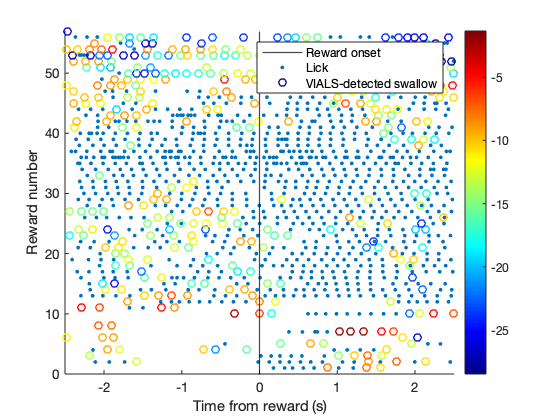

In [14]:
%% Raster plot

% tp(any(isnan(tp(:,3)),2),:) = [];
[rp,aligned] = plotRaster(tp,pswallow,emgswallow,camdata);
colormap(jet); colorbar
rp_path = strcat('Videos/',session,'/','rp.svg');
legend

In [26]:
% Input time
% rewardid = 20;
% rdiff = -1;
% t = camdata.reward(rewardid,1) + rdiff - 1;
t = 1;
floor = time2frame(t,camdata);
ceiling = floor + 1000;
time = frame2time(floor:ceiling,camdata);

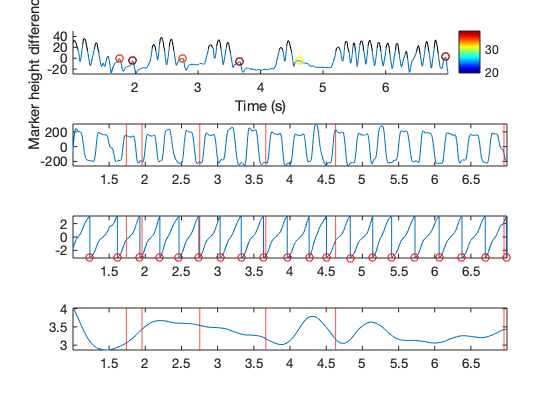

In [27]:
%% Swallowing + breathing

% hdiff
pks = find(pswallow(:,2) >= time(1) & pswallow(:,2) <= time(size(time,1)));
% lici = find(longici(:,3) >= floor & longici(:,4) <= ceiling);

figure
subplot(4,1,1)
% for i = 1:size(lici) 
%     xline(frame2time(longici(lici(i),3),camdata),'-b');
%     hold on
%     xline(frame2time(longici(lici(i),4),camdata),'-b'); 
% end 
hold on
% plotBouts('swallowbout',skinbout,floor,ceiling,camdata);
hold on
plot(frame2time(loc(:,1),camdata),hdiff);
hold on
scatter(pswallow(:,2),pswallow(:,3),36,pswallow(:,5),'o','LineWidth',1);
colormap(jet); colorbar
hold on
plotConditionalTraj('traj',frame2time(loc(:,1),camdata),hdiff,tp);
xlabel('Time (s)')
ylabel('Marker height difference (a.u.)')
xlim([time(1) time(length(time))]);

subplot(4,1,2)
plot(breathing.raw(:,1),breathing.trace);
hold on
for i = 1:size(pks,1)
    xline(pswallow(pks(i),2),'-r');
end
xlim([time(1) time(length(time))]);

subplot(4,1,3)
plot(breathing.raw(:,1),breathing.phase);
hold on
for i = 1:size(pks,1)
    xline(pswallow(pks(i),2),'-r');
end
scatter(breathing.raw(breathing.count,1),breathing.phase(breathing.count),'or');
xlim([time(1) time(length(time))]);

subplot(4,1,4)
plot(breathing.raw(:,1),breathing.frequency);
hold on
for i = 1:size(pks,1)
    xline(pswallow(pks(i),2),'-r');
end
xlim([time(1) time(length(time))]);

In [ ]:
%% Breathing and swallowing
swins = 0;
sb = [];
for i = 1:size(pswallow,1)
    [~,index] = findClosest(breathing.raw(:,1),pswallow(i,2));
    % if pswallow happens during in inspiration (dbreathing < -500)
    if breathing.d(index) <= -500
        swins = swins + 1;
    end
    sb = [sb; pswallow(i,1) pswallow(i,2),...
        breathing.trace(index) breathing.phase(index) breathing.d(index)];
end

In [ ]:
figure
scatterhistogram(sb(:,3),pswallow(:,2),'HistogramDisplayStyle','smooth');
xlabel('Trace')
figure
scatterhistogram(sb(:,4),pswallow(:,2),'HistogramDisplayStyle','smooth');
xlabel('Phase') 
figure 
scatterhistogram(sb(:,5),pswallow(:,2),'HistogramDisplayStyle','smooth');
xlabel('Derivative value')

In [ ]:
%% Swallowing + EMG

% Trajectory plot
%{
19-111119-1;
only es: 5x, 17x, 24, 25, 25, 27, 28, 33, 33, 35, 39, 40, 41
only vs: 110-112s
%}

% hdiff
pks = find(pswallow(:,2) >= time(1) & pswallow(:,2) <= time(size(time,1)));
% lici = find(longici(:,3) >= floor & longici(:,4) <= ceiling);

figure
subplot(1,1,1)
% for i = 1:size(lici) 
%     xline(frame2time(longici(lici(i),3),camdata),'-b');
%     hold on
%     xline(frame2time(longici(lici(i),4),camdata),'-b'); 
% end 
hold on
% plotBouts('swallowbout',skinbout,floor,ceiling,camdata);
hold on
plot(frame2time(loc(:,1),camdata),hdiff);
hold on
scatter(pswallow(:,2),pswallow(:,3),36,pswallow(:,5),'o','LineWidth',1);
colormap(jet); colorbar
hold on
plotConditionalTraj('traj',frame2time(loc(:,1),camdata),hdiff,tp);
xlabel('Time (s)')
ylabel('Marker height difference (a.u.)')
xlim([time(1) time(length(time))]);

% hdiff + EMG
% Find peaks of EMG envelope
[envpeaks,envplocs] = findpeaks(emgenv(:,2),...
    'MinPeakDistance',3000,'MinPeakProminence',20);
subplot(1,1,2)
plot(emg(:,1),emg(:,2),'Color','#4DBEEE');
hold on
plot(emgenv(:,1),emgenv(:,2),'LineWidth',1);
for i = 1:size(pks,1)
    xline(pswallow(pks(i),2),'-r');
end
hold on
%{
for i = 1:size(lici) 
    xline(frame2time(longici(lici(i),3),camdata),'-b');
    hold on
    xline(frame2time(longici(lici(i),4),camdata),'-b'); 
end
hold on
% for i = 1:size(camdata.reward,1)
%     xline(camdata.reward(i),'-k');
% end
hold on
% plotConditionalTraj('emg',frame2time(loc(:,1),camdata),emgenv,tp);
hold on
%}
plot(emgenv(envplocs,1),envpeaks,'oc');
hold on
plot(emgenv(emgswallow(:,3),1),emgswallow(:,4),'ob');
xlabel('Time (s)')
ylabel('EMG amplitude (a.u.)')
xlim([time(1) time(length(time))]);

In [ ]:
%% Quantify swallow and licking movement
disp('----- Quantify swallow and lick movement -----');

% Percentage of pswallow in ici threshold ms longer than previous ici
%  5 ms: 84.17%, 10 ms: 82.92%, 15 ms: 82.08%, 20 ms: 81.25%
numerator = 0;
for i = 1:size(pswallow,1)
    inlici = find(pswallow(i,2) >= longici(:,3) & pswallow(i,2) <= longici(:,4),1);
    if ~isempty(inlici)
        numerator = numerator + 1;
    end
end
disp(numerator / size(pswallow,1));

% Percentage vs ici threshold
percentage = [];
for thres = -0.5:0.005:0.5
    testici = findExtendedICI(tp,thres);
    numerator = 0;
    for i = 1:size(pswallow,1)
        inlici = find(pswallow(i,2) >= testici(:,3) & pswallow(i,2) <= testici(:,4),1);
        if ~isempty(inlici)
            numerator = numerator + 1;
        end
    end
    percentage = [percentage; thres, numerator / size(pswallow,1)];
end
figure
plot(percentage(:,1),percentage(:,2));

% Number of tp preceeding pswallow in a bout

In [ ]:
%% Tongue trajectory PCA
disp('----- Tongue Trajectory PCA -----');
% path = 

all = ["11-062419-1"; "11-062819-1"; "12-070519-2"; "13-090919-1";...
    "14-091519-1"; "18-102119-1"; "18-102519-1"; "18-102519-2";...
    "19-111119-1"];
mid = ["11-062419-1";"14-091519-1"];  % total: 14856 (8186+)
left = ["11-062819-1"; "12-070519-2"];  % total: 12576 (9074+)
animal = all(2);

% v1: 'dur','pLen','ampX/Y/Z','tpDevS/B','ilmPer'
% v2: 'dur','pLen','ampX/Y/Z','tpDevS/B','pPer/Vel','ilmPer/Vel','rPer/Vel'
version = 2;
dimension = 2;
[b,total,pcadata,kmdata] = tpClustering(left,version,dimension);

% figure
% bar(1:size(pcadata.explained,1),pcadata.explained);
% xlabel('Principle component');
% ylabel('Percentage of total variance explained');

In [ ]:
%% PCA data analysis
disp('------');

% retrieve observations closest to the centroid
[~,sw] = min(kmdata.d(:,1));
[~,se] = min(kmdata.d(:,2));
[~,nw] = min(kmdata.d(:,3));
[~,ne] = min(kmdata.d(:,4));

% Centroid samples
%{
SW: mid: 1-1972 left: 2-2055
SE: mid: 1-5040 left: 1-4501
NW: mid: 2-1850 left: 1-4038
NE: mid: 2-4958 left: 2-1831
%}

% sessions
all = ["11-062419-1"; "11-062819-1"; "12-070519-2"; "13-090919-1";...
    "14-091519-1"; "18-102119-1"; "18-102519-1"; "18-102519-2";...
    "19-111119-1"];
mid = ["11-062419-1";"14-091519-1"];  % total: 14856 (8186+)
left = ["11-062819-1"; "12-070519-2"];  % total: 12576 (9074+)
tp_path = strcat('Videos/',mid(1),'/tp.csv');
tp = readmatrix(tp_path);

% tpid = 
disp(tp(tpid,:));

% form a tp table
% ctp = [];
% ctp = [ctp; tp(total(ne,2),:)];

In [ ]:
%% Plot tongue trajectory
disp('----- Plot tongue trajectory -----');

phase = 1;         % separate different lick phases or not

mid = ["11-062419-1";"14-091519-1"];  % total: 14856 (8186+)
left = ["11-062819-1";"12-070519-2"];  % total: 12576 (9074+)
session = mid(1);
disp(session);

% ctpid = transpose(ctp(:,1));
% tpid = ctpid(3);
tpid = 276;
% tpid = [2162 2566 1305 2409 2157; 2823 910 2442 1943 2626] + 17; % 12-070519-2, v1
% tpid = [2841 2873 2880 2874 2856; 2568 2521 1142 2560 2601] + 17; % 12-070519-2, v2

% figure
plotTongueTraj(phase,tpid,session,0,1);

In [ ]:
%% Subclassify tp data
%{
ilmCount = nnz(tp(:,17));
noilmCount = size(tp,1) - ilmCount;
scCount = nnz(tp(:,2));
nscCount = size(tp,1) - scCount;
nsctoscCount = 0;
disp(strcat('ILM/all=',num2str(ilmCount/size(tp,1))));

% ILM licks <-> first/last lick of the lickbout
bsandilm = 0;       % First lick of the lickbout <-> ILM licks
bethenilm = 0;      % Last lick of the lickbout --> ILM licks?
beandnoilm = 0;
for i = 1:size(lickbout,1)
    if tp(lickbout(i,4),17) ~= 0
        bsandilm = bsandilm + 1;
    end
    
    if lickbout(i,5)+1 < size(tp,1) 
        if tp(lickbout(i,5)+1,17) ~= 0
            bethenilm = bethenilm + 1;
        end
    end
    
    if tp(lickbout(i,5),17) == 0
        beandnoilm = beandnoilm + 1;
    end
end
disp('-------');
disp(strcat('ILM/lickboutStart=',num2str(bsandilm/size(lickbout,1))));
disp(strcat('lickboutStart/ILM=',num2str(bsandilm/ilmCount)));
disp(strcat('lickboutEnd+1/ILM=',num2str(bethenilm/ilmCount)));
disp(strcat('ILM/lickboutEnd+1=',num2str(bethenilm/(size(lickbout,1)-1))));
disp(strcat('noILM/lickboutEnd=',num2str(beandnoilm/(size(lickbout,1)))));
disp(strcat('lickboutEnd/noILM=',num2str(beandnoilm/noilmCount)));

% ILM licks <-> isLick=0
nscandilm = 0;
nscthenilm = 0;
scthennoilm = 0;
nsctosctonoilm = 0;
for i = 1:size(tp,1)
   if tp(i,2) == 0
       if tp(i,17) ~= 0
           nscandilm = nscandilm + 1;
       end
       if i+1 < size(tp,1)
           if tp(i+1,17) ~= 0
               nscthenilm = nscthenilm + 1;
           end
       end
   else
       if i+1 < size(tp,1)
           if tp(i+1,17) == 0
               scthennoilm = scthennoilm + 1;
           end
       end
       if i+1 < size(tp,1) && i-1 > 0
           if tp(i-1,2) == 0
               nsctoscCount = nsctoscCount + 1;
               if tp(i+1,17) == 0
                   nsctosctonoilm = nsctosctonoilm + 1;
               end
           end
       end
   end
end
disp('-------');
disp(strcat('noSC/ILM=',num2str(nscandilm/nscCount)));
disp(strcat('noSC+1/ILM=',num2str(nscthenilm/nscCount)));
disp(strcat('SC+1/noILM=',num2str(scthennoilm/noilmCount)));
disp(strcat('noSC->SC->noILM/noSC->SC=',num2str(nsctosctonoilm/nsctoscCount)));
disp(strcat('ILM/noSC+1=',num2str(nscthenilm/nscCount)));
disp(strcat('noILM/SC+1=',num2str(scthennoilm/scCount)));

disp('----------------------');
%}

In [ ]:
%% ILI per licking bout
bid = 3;
floor = lickbout(bid,6);
ceiling = lickbout(bid,7);
pks = find(pswallow(:,2) >= floor & pswallow(:,2) <= ceiling);
lici = find(longici(:,3) >= floor & longici(:,4) <= ceiling);

figure
for i = 1:size(lici) 
    xline(longici(lici(i),3),'-r');
    hold on
    xline(longici(lici(i),4),'-r'); 
end
hold on
plotBouts('swallowbout',swallowbout,floor,ceiling);
hold on
plot(loc(floor:ceiling,1),hdiff(floor:ceiling),'DisplayName','Laryngeal y corrected');
hold on
plot(pswallow(pks,2),pswallow(pks,3),'or');
hold on
plotConditionalTraj('tp',loc(:,1),hdiff,tp,floor,ceiling);

% figure
% plotILI(bid,lickbout,tp,'frame');

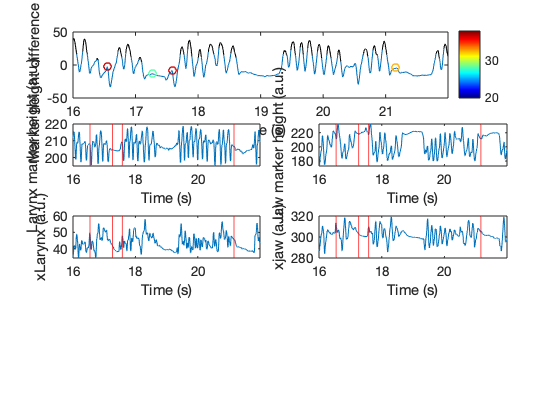

In [28]:
%% Trace

floor = time2frame(16,camdata);
ceiling = floor + 1000;
time = frame2time(floor:ceiling,camdata);
pks = find(pswallow(:,2) >= time(1) & pswallow(:,2) <= time(size(time,1)));

figure
subplot(4,2,[1 2])
plot(frame2time(loc(:,1),camdata),hdiff);
hold on
scatter(pswallow(:,2),pswallow(:,3),36,pswallow(:,5),'o','LineWidth',1);
colormap(jet); colorbar
hold on
plotConditionalTraj('traj',frame2time(loc(:,1),camdata),hdiff,tp);
xlim([time(1) time(length(time))]);
xlabel('Time (s)')
ylabel('Marker height difference (a.u.)')

% figure
subplot(4,2,3)
plot(frame2time(loc(:,1),camdata),loc(:,11));   % ylary
hold on
for i = 1:size(pks,1)
    xline(pswallow(pks(i),2),'-r');
end
xlabel('Time (s)')
ylabel('Larynx marker height (a.u.)')
xlim([time(1) time(length(time))]);

subplot(4,2,4)
plot(frame2time(loc(:,1),camdata),loc(:,14));   % yjaw
hold on
for i = 1:size(pks,1)
    xline(pswallow(pks(i),2),'-r');
end
xlabel('Time (s)')
ylabel('Jaw marker height (a.u.)')
xlim([time(1) time(length(time))]);

subplot(4,2,5)
plot(frame2time(loc(:,1),camdata),loc(:,10)); % xlary
hold on
for i = 1:size(pks,1)
    xline(pswallow(pks(i),2),'-r');
end
xlabel('Time (s)')
ylabel('xLarynx (a.u.)')
xlim([time(1) time(length(time))]);

subplot(4,2,6)
plot(frame2time(loc(:,1),camdata),loc(:,13)); % xjaw
hold on
for i = 1:size(pks,1)
    xline(pswallow(pks(i),2),'-r');
end
xlabel('Time (s)')
ylabel('xjaw (a.u.)')
xlim([time(1) time(length(time))]);

% subplot(4,2,5)
% plot(frame2time(loc(:,1),camdata),smoothdata(velhdiff));   % velhdiff
% hold on
% for i = 1:size(pks,1)
%     xline(pswallow(pks(i),2),'-r');
% end
% xlabel('Time (s)')
% ylabel('Velocity of hdiff (a.u.)')
% xlim([time(1) time(length(time))]);
% 
% subplot(4,2,6)
% plot(frame2time(loc(:,1),camdata),smoothdata(velyjaw));   % velyjaw
% hold on
% for i = 1:size(pks,1)
%     xline(pswallow(pks(i),2),'-r');
% end
% xlabel('Time (s)')
% ylabel('Velocity of yjaw (a.u.)')
% xlim([time(1) time(length(time))]);

% subplot(4,2,7)
% plot(frame2time(loc(:,1),camdata),smoothdata(acchdiff));   % acchdiff
% hold on
% for i = 1:size(pks,1)
%     xline(pswallow(pks(i),2),'-r');
% end
% xlabel('Time (s)')
% ylabel('Accelaration of hdiff (a.u.)')
% xlim([time(1) time(length(time))]);

% subplot(4,2,8)
% plot(frame2time(loc(:,1),camdata),smoothdata(accyjaw));   % accyjaw
% hold on
% for i = 1:size(pks,1)
%     xline(pswallow(pks(i),2),'-r');
% end
% xlabel('Time (s)')
% ylabel('Accelaration of yjaw (a.u.)')
% xlim([time(1) time(length(time))]);

Putative swallow found


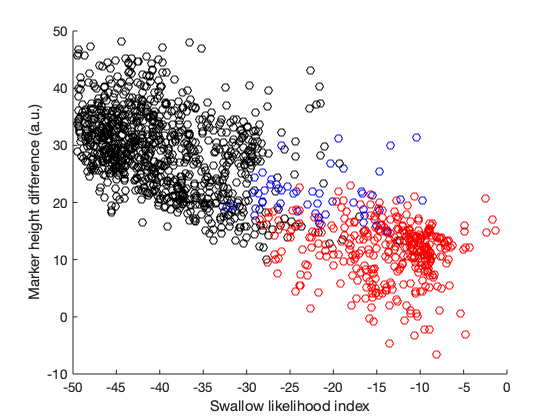

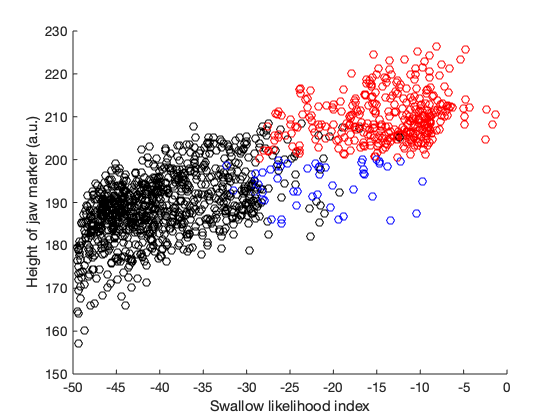

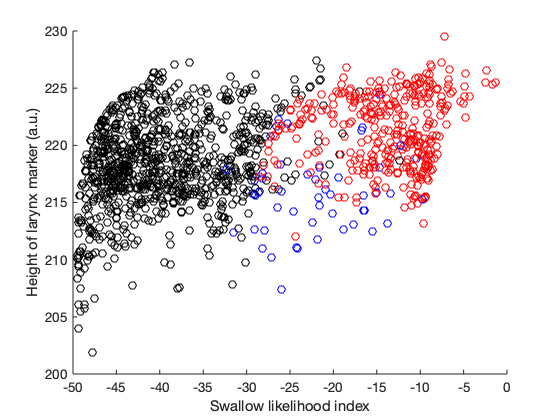

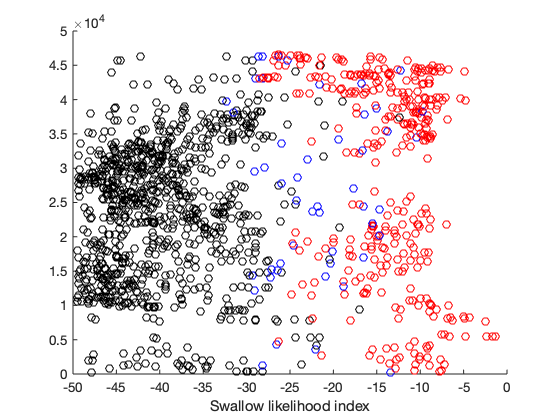

In [15]:
%% pswallow distribution

[pswallow,inthres,allpeaks] = defineSwallows(loc,tp,camdata);

figure
for i = 1:size(allpeaks.sli)
    hold on
    if allpeaks.sli(i,2) == 0
        scatter(allpeaks.sli(i,1),allpeaks.locs(i),'ok');
    elseif allpeaks.sli(i,2) == 1
        scatter(allpeaks.sli(i,1),allpeaks.locs(i),'ob');
    else
        scatter(allpeaks.sli(i,1),allpeaks.locs(i),'or');
    end
end
xlabel('Swallow likelihood index');
ylabel('Time (s)');

figure
for i = 1:size(allpeaks.sli)
    hold on
    if allpeaks.sli(i,2) == 0
        scatter(allpeaks.sli(i,1),loc(allpeaks.locs(i),11),'ok');
    elseif allpeaks.sli(i,2) == 1
        scatter(allpeaks.sli(i,1),loc(allpeaks.locs(i),11),'ob');
    else
        scatter(allpeaks.sli(i,1),loc(allpeaks.locs(i),11),'or');
    end
end
xlabel('Swallow likelihood index');
ylabel('Height of larynx marker (a.u.)');

figure
for i = 1:size(allpeaks.sli)
    hold on
    if allpeaks.sli(i,2) == 0
        scatter(allpeaks.sli(i,1),loc(allpeaks.locs(i),14),'ok');
    elseif allpeaks.sli(i,2) == 1
        scatter(allpeaks.sli(i,1),loc(allpeaks.locs(i),14),'ob');
    else
        scatter(allpeaks.sli(i,1),loc(allpeaks.locs(i),14),'or');
    end
end
xlabel('Swallow likelihood index');
ylabel('Height of jaw marker (a.u.)');

figure
for i = 1:size(allpeaks.sli)
    hold on
    if allpeaks.sli(i,2) == 0
        scatter(allpeaks.sli(i,1),hdiff(allpeaks.locs(i)),'ok');
    elseif allpeaks.sli(i,2) == 1
        scatter(allpeaks.sli(i,1),hdiff(allpeaks.locs(i)),'ob');
    else
        scatter(allpeaks.sli(i,1),hdiff(allpeaks.locs(i)),'or');
    end
end
xlabel('Swallow likelihood index');
ylabel('Marker height difference (a.u.)');